Name: Aayam Raj Shakya (as5160)

In [ ]:
# importing required libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

(Exploring and designing a deep network). Popular deep learning packages are summarized on page 302. Choose one of them to design a CNN for the MNIST dataset. For each one, if you choose a simple CNN, its test accuracy will become approximately 99%. You can make it better through appropriate additions and modifications. For example, you may try:

(a) Set multiple convolution-pooling layers.

(b) Choose various number of hidden layers and units on each layer.

(c) Select various activation functions.

Explore the package of your choice yourself, to design a CNN showing an accuracy
better than 99.5%.

In [ ]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download training data from open datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

# Download test data from open datasets
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

100.0%
100.0%
100.0%
100.0%


In [ ]:
print(f"Training Data: {training_data}")
print(f"\nTest Data: {test_data}")

Training Data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[-20.0, 20.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
               ToTensor()
           )

Test Data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


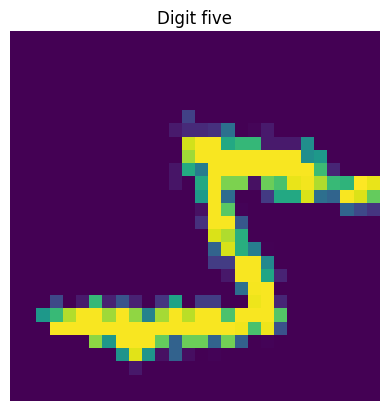

In [ ]:
# Label-mapping for MNIST dataset
label_map = {0: "zero",
             1: "one",
             2: "two",
             3: "three",
             4: "four",
             5: "five",
             6: "six",
             7: "seven",
             8: "eight",
             9: "nine"}

# Visualize the first image in the training dataset
first_image = training_data[0][0].reshape((28, 28))
first_label = training_data[0][1]

plt.imshow(first_image)
plt.title("Digit %s" % label_map[first_label])
plt.axis("off")
plt.show()

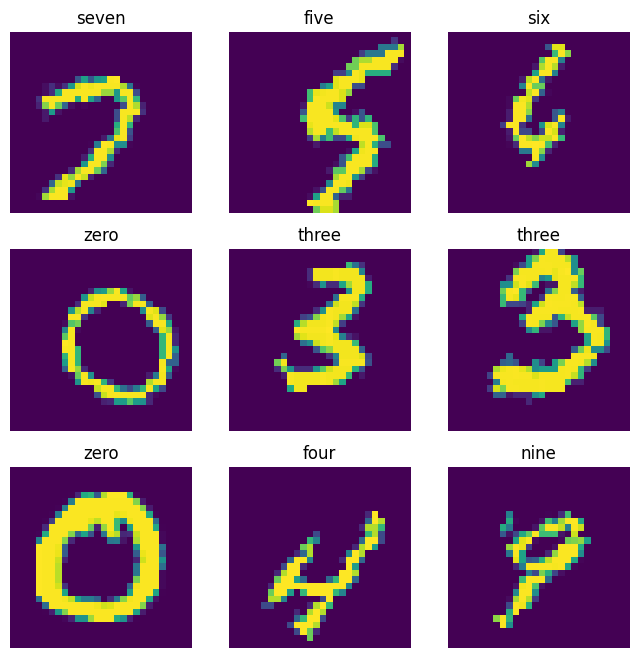

In [ ]:
# Visualize multiple images from the training dataset
fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1, )).item()
  img, label = training_data[sample_idx]
  fig.add_subplot(rows, cols, i)
  plt.title(label_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze())
plt.show()

We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
128, i.e. each element in the dataloader iterable will return a batch of
128 features and labels.

In [ ]:
batch_size = 128

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"Number of batches in the training set: {len(train_dataloader)}")
print(f"Number of batches in the test set: {len(test_dataloader)}")

for batched_x, batched_y in test_dataloader:
    # batched_x is one batch of images
    # N, C, H, W = batch_size, channel, height, width
    print(f"Shape of batched_x [N, C, H, W]: {batched_x.shape} {batched_x.dtype}")

    # batched_y is one batch of labels
    print(f"Shape of batched_y: {batched_y.shape} {batched_y.dtype}")
    break

Number of batches in the training set: 469
Number of batches in the test set: 79
Shape of batched_x [N, C, H, W]: torch.Size([128, 1, 28, 28]) torch.float32
Shape of batched_y: torch.Size([128]) torch.int64


Convolutional Neural Networks
---

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# My initial model with accuracy of 99.0%
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class NeuralNetwork(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
      self.norm1 = nn.BatchNorm2d(num_features=64)

      self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
      self.norm2 = nn.BatchNorm2d(num_features=64)

      self.pool1 = nn.MaxPool2d(2, 2)
      self.drop1 = nn.Dropout(0.25)

      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
      self.norm3 = nn.BatchNorm2d(num_features=128)

      self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
      self.norm4 = nn.BatchNorm2d(num_features=128)

      self.pool2 = nn.MaxPool2d(2, 2)
      self.drop2 = nn.Dropout(0.25)

      self.flatten = nn.Flatten()
      # to calculate the in_features for the fully-connected layers,
      # take the output of the last conv layer (64; 8x8)
      # the kernel size and stride of the max-pool after that is (2, 2), so the
      # conv layer output dim will be reduced down to 4x4
      self.dense1 = nn.Linear(128*4*4, 512)
      self.norm5 = nn.BatchNorm1d(num_features=512)

      self.drop3 = nn.Dropout(0.5)

      self.dense2 = nn.Linear(512, 10)

    def forward(self, x):

      x = F.relu(self.norm1(self.conv1(x)))
      x = self.drop1(self.pool1(self.norm2(self.conv2(x))))
      x = F.relu(self.norm3(self.conv3(x)))

      x = self.drop2(self.pool2(self.norm4(self.conv4(x))))

      x = self.flatten(x)
      x = F.relu(self.norm5(self.dense1(x)))

      x = self.drop3(x)
      x = self.dense2(x)
      return x

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=2048, out_features=512

Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

Running a single iteration is usually not sufficient to train the network. We can repeat this process by running the forward and backward passes within a training loop. In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

In [ ]:
# Training loop
def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    losses=[]
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error and perform backpropagation
        pred = model(X)
        loss = loss_fn(pred, y)

        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    mean_loss = sum(losses) / len(losses)
    mean_loss = round(mean_loss, 2)
    scheduler.step(mean_loss)

We also check the model's performance against the test dataset to ensure it is learning.

In [ ]:
# Testing loop
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            # Compute prediction and calculate the accuracy
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.

In [ ]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.410385  [  128/60000]
loss: 0.300840  [12928/60000]
loss: 0.201266  [25728/60000]
loss: 0.298582  [38528/60000]
loss: 0.194686  [51328/60000]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.039588 

Epoch 2
-------------------------------
loss: 0.164834  [  128/60000]
loss: 0.109721  [12928/60000]
loss: 0.179911  [25728/60000]
loss: 0.173367  [38528/60000]
loss: 0.114067  [51328/60000]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.036946 

Epoch 3
-------------------------------
loss: 0.122694  [  128/60000]
loss: 0.086378  [12928/60000]
loss: 0.159435  [25728/60000]
loss: 0.159642  [38528/60000]
loss: 0.100776  [51328/60000]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.024859 

Epoch 4
-------------------------------
loss: 0.092434  [  128/60000]
loss: 0.075275  [12928/60000]
loss: 0.111268  [25728/60000]
loss: 0.124010  [38528/60000]
loss: 0.163836  [51328/60000]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.026861 

Epoch 5
------------------------

Saving Models
=============

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.

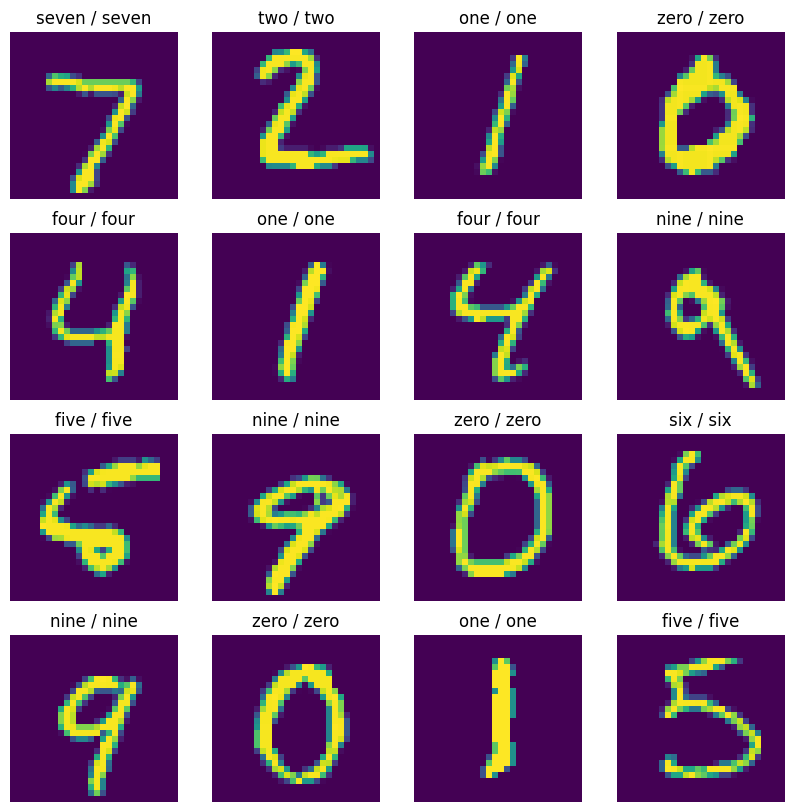

In [ ]:
model.eval()

# Visualize a few test samples along with their predicted classes
plt.figure(figsize=(10,10))
test_images, test_labels = next(iter(test_dataloader))
test_predictions = model(test_images.to(device))
predicted_labels = test_predictions.max(1)[1]

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[i].reshape((28, 28)))
    plt.title("%s / %s" % (label_map[int(predicted_labels[i])], label_map[int(test_labels[i])]))
    plt.axis('off')

# PREDICTED / ACTUAL